## AirBnB Effect
#### There is considerable empirical research on the effect of short-term rental led gentrification on the renting market, housing stock and demographical make-up of city centres. In spite of its considerable pros and cons, AirBnB market is an efficient market with high volumes of interaction and a competitive pricing model.

#### Let's delve into this pricing model and predict what affects the price per guest of a listing.

## Components of the Notebook

#### 1. Exploratory Data Analysis
#### 2. Data Cleaning
#### 3. Feature Engineering
#### 4. Encoding Categorical Features
#### 5. Natural Language Processing
#### 6. Bringing it all together - Machine Learning
#### 7. Give it a go

### AIM: Develop a model to predict the price per guest for AirBnB listings from the Greater London area. 

### Data Source: InsideAirBnB:  http://insideairbnb.com/get-the-data.html

In [2]:
!pip install folium nltk textblob

  Using cached folium-0.12.1-py2.py3-none-any.whl (94 kB)
  Using cached textblob-0.15.3-py2.py3-none-any.whl (636 kB)
  Using cached branca-0.4.2-py3-none-any.whl (24 kB)


In [3]:
# Let's import the boilerplate code. The main 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import mpl_toolkits
from datetime import datetime
import geopandas
import folium
import mpl_toolkits
import nltk
import textblob
pd.set_option('display.max_columns', None)

## 2. Import Data

In [4]:
data_folder='../../data/airbnb/'
#files: calendar.csv.gz  listings_summary.csv    reviews.csv.gz
# listings.csv     neighbourhoods.csv      reviews_summary.csv
# listings.csv.gz  neighbourhoods.geojson

data_calendar = pd.read_csv(data_folder+"calendar.csv")
data_listings_summary=pd.read_csv(data_folder+"listings_summary.csv")
data_reviews = pd.read_csv(data_folder+"reviews.csv.gz")
data_listings = pd.read_csv(data_folder+"listings.csv",low_memory=False, parse_dates=True)
data_neighbourhoods= pd.read_csv(data_folder+"neighbourhoods.csv", low_memory=False)
data_review_summary=pd.read_csv(data_folder+"reviews_summary.csv")
data_neighbourhoods_geo=pd.read_json(data_folder+"neighbourhoods.geojson")


## 3. Clean Data
- Remove non-GB based listings
- Remove listings with per day price is greater than £x.00 i.e. any artificial skews in the data
- Remove listings with price, bed etc set as £0
- Remove listings where reviews are in a non-english language

In [5]:
data_listings.drop(data_listings[data_listings.country_code!="GB"].index.values,axis=0,inplace=True)

In [6]:
#the price variable is in the summary file
data_listings['price2'] = data_listings['id'].map(data_listings_summary.set_index('id')['price'])

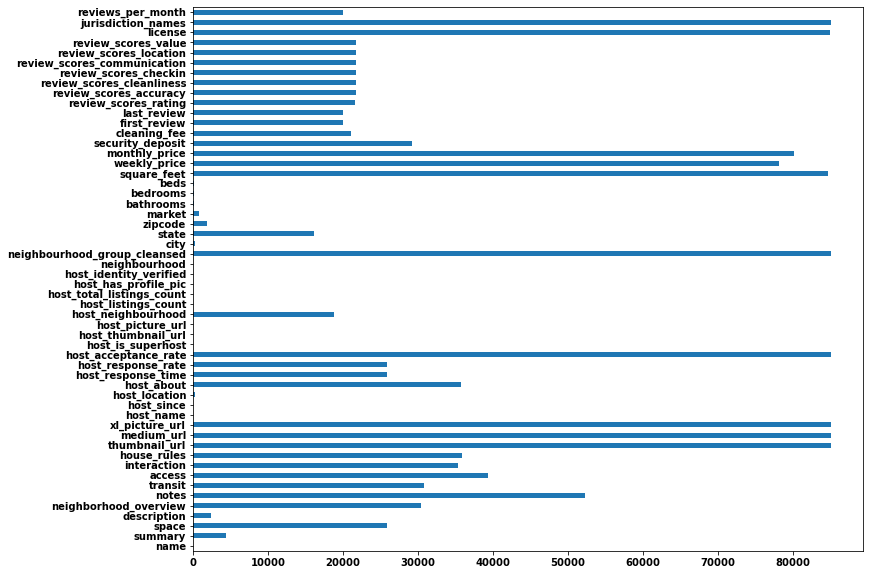

In [7]:
#Examine the null data and missing values
data_listings.isnull().sum()[data_listings.isnull().sum()>0].plot(kind='barh',figsize=(12,10));

### 3a. Dropping meaningful variables with null and or 0 values


In [8]:
data_listings.drop(data_listings[data_listings.beds==0].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.beds.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_rating.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_cleanliness.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.review_scores_location.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_is_superhost.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.host_has_profile_pic.isnull()].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.property_type=="Parking Space"].index.values,axis=0, inplace=True)
data_listings.drop(data_listings[data_listings.price2==10000].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2>250].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.price2==0].index.values,inplace=True)
data_listings.drop(data_listings[data_listings.reviews_per_month.isnull()].index.values,axis=0, inplace=True)

In [9]:
#Let's trim unnecessary columns like url to streamline our data
data_listings.drop(["scrape_id","listing_url","interaction","notes","thumbnail_url","medium_url","picture_url","host_url","host_name","host_response_time","host_response_rate","host_acceptance_rate","host_thumbnail_url","host_picture_url","host_listings_count","host_verifications","host_identity_verified"],axis=1,inplace=True)
data_listings.drop(["first_review","license","jurisdiction_names","requires_license","require_guest_phone_verification"],axis=1,inplace=True)
data_listings.drop(["xl_picture_url","host_location","market","smart_location","country_code","country","is_location_exact"],axis=1,inplace=True)
data_listings.drop(["host_neighbourhood","street","square_feet","weekly_price","monthly_price","security_deposit","cleaning_fee","guests_included","review_scores_accuracy","review_scores_checkin","review_scores_communication","review_scores_value"],axis=1,inplace=True)
data_listings.drop(["neighbourhood_group_cleansed","minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated","calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms","calculated_host_listings_count_shared_rooms"],axis=1,inplace=True)
data_listings.drop(["transit","zipcode","city","state"],axis=1,inplace=True)
data_listings.drop(['maximum_nights','minimum_minimum_nights', 'maximum_minimum_nights','minimum_maximum_nights', 'maximum_maximum_nights'],axis=1,inplace=True)
data_listings.drop(["bathrooms","bedrooms","neighbourhood",'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'calendar_last_scraped',"is_business_travel_ready"],axis=1,inplace=True)
data_listings.drop(["has_availability","extra_people"],axis=1,inplace=True)
data_listings.drop(["number_of_reviews_ltm"],axis=1,inplace=True)

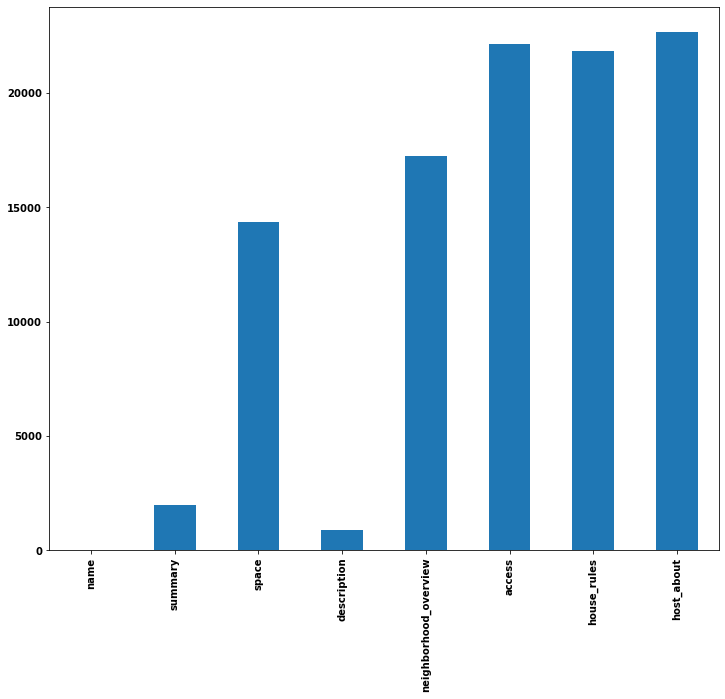

In [10]:
#Let's visualise now:
#Examine the null data and missing values
data_listings.isnull().sum()[data_listings.isnull().sum()>0].plot(kind='bar',figsize=(12,10));

In [11]:
#Let's review our final data
data_listings.describe()


id       host_id  host_total_listings_count      latitude  \
count  5.804300e+04  5.804300e+04               58043.000000  58043.000000   
mean   2.215230e+07  8.001090e+07                  14.663008     51.509756   
std    1.097100e+07  8.254389e+07                  82.217564      0.045979   
min    1.155100e+04  2.697000e+03                   0.000000     51.294790   
25%    1.399436e+07  1.351023e+07                   1.000000     51.485210   
50%    2.255858e+07  4.395094e+07                   2.000000     51.514360   
75%    3.168062e+07  1.335221e+08                   4.500000     51.537670   
max    3.985872e+07  3.056321e+08                1270.000000     51.681690   

          longitude  accommodates          beds  minimum_nights  \
count  58043.000000  58043.000000  58043.000000    58043.000000   
mean      -0.126688      3.077443      1.701290        3.785556   
std        0.091968      1.787826      1.102879       15.847233   
min       -0.495820      1.000000      1.000000        1.000000   
25%       -0.187650      2.000000      1.000000        1.000000   
50%       -0.121870      2.000000      1.000000        2.000000   
75%       -0.068750      4.000000      2.000000        3.000000   
max        0.272080     30.000000     20.000000     1124.000000   

       number_of_reviews  review_scores_rating  review_scores_cleanliness  \
count       58043.000000          58043.000000               58043.000000   
mean           23.830333             92.570853                   9.263787   
std            41.533819             10.043345                   1.134203   
min             1.000000             20.000000                   2.000000   
25%             3.000000             90.000000                   9.000000   
50%             9.000000             96.000000                  10.000000   
75%            26.000000            100.000000                  10.000000   
max           716.000000            100.000000                  10.000000   

       review_scores_location  reviews_per_month        price2  
count            58043.000000       58043.000000  58043.000000  
mean                 9.530452           1.245031     89.523974  
std                  0.815296           1.432451     54.285581  
min                  2.000000           0.010000      1.000000  
25%                  9.000000           0.260000     45.000000  
50%                 10.000000           0.770000     79.000000  
75%                 10.000000           1.690000    120.000000  
max                 10.000000          20.130000    250.000000

## 4. Evaluate price variable

In [12]:
data_listings['price_per_guest']=data_listings['price2']/data_listings['accommodates']

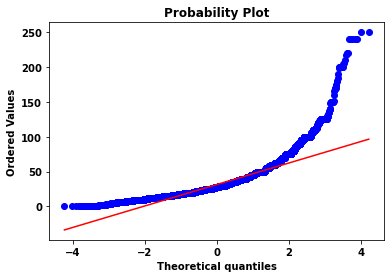

In [13]:
from scipy import stats
res = stats.probplot(data_listings['price_per_guest'], plot=mpl.pyplot)


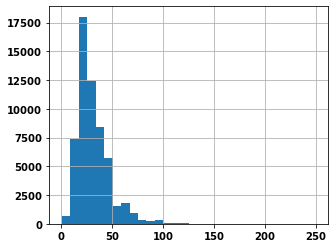

In [14]:
data_listings.price_per_guest.hist(bins=30,figsize=(5,4));

In [15]:
## Let's check for skew and kurtosis
print("Skewness before log transform: ", data_listings.price_per_guest.skew())
print("Kurtosis before log transform: ",data_listings.price_per_guest.kurt())


Skewness before log transform:  2.2195241380417405
Kurtosis before log transform:  11.116117148856201


#### The target variable is right skewed with significant kurtosis. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed

Skewness before log transform:  -0.04883716202795978
Kurtosis before log transform:  1.0926223081728863


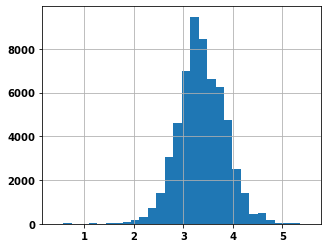

In [16]:
Y = np.log1p(data_listings.price_per_guest)
print("Skewness before log transform: ", Y.skew())
print("Kurtosis before log transform: ",Y.kurt())
#Let's visulaise the histogram
Y.hist(bins=30,figsize=(5,4));

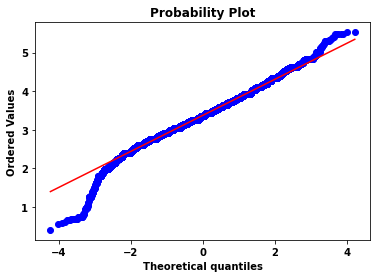

In [17]:
#Look's much better, let's normalise
data_listings.price_per_guest = np.log1p(data_listings.price_per_guest)
res = stats.probplot(data_listings['price_per_guest'], plot=mpl.pyplot)


## 5. EDA

In [18]:
# Let's start with some basic visualisations

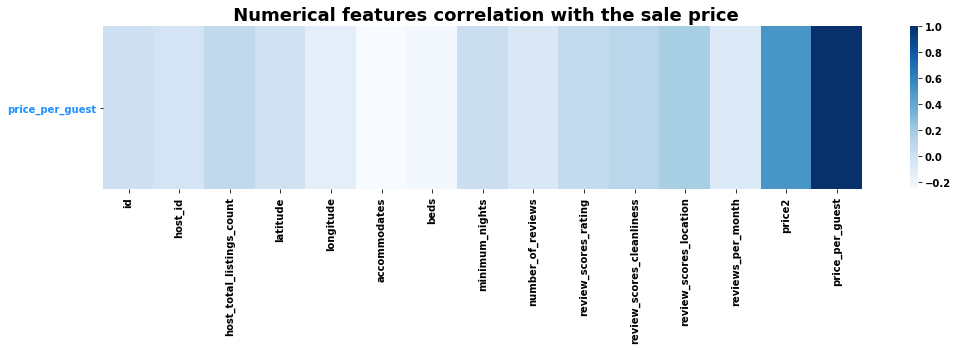

In [19]:
num=data_listings.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=mpl.pyplot.subplots(figsize=(17,3))
sns.heatmap(numcorr.sort_values(by=['price_per_guest'], ascending=False).head(1), cmap='Blues')
mpl.pyplot.title(" Numerical features correlation with the sale price", weight='bold', fontsize=18)
mpl.pyplot.xticks()
mpl.pyplot.yticks(weight='bold', color='dodgerblue', rotation=0)


mpl.pyplot.show()

### We can see there is some degree of correlation with latitide and longitude, i.e Londone Fare Zones - let's expplore this variable

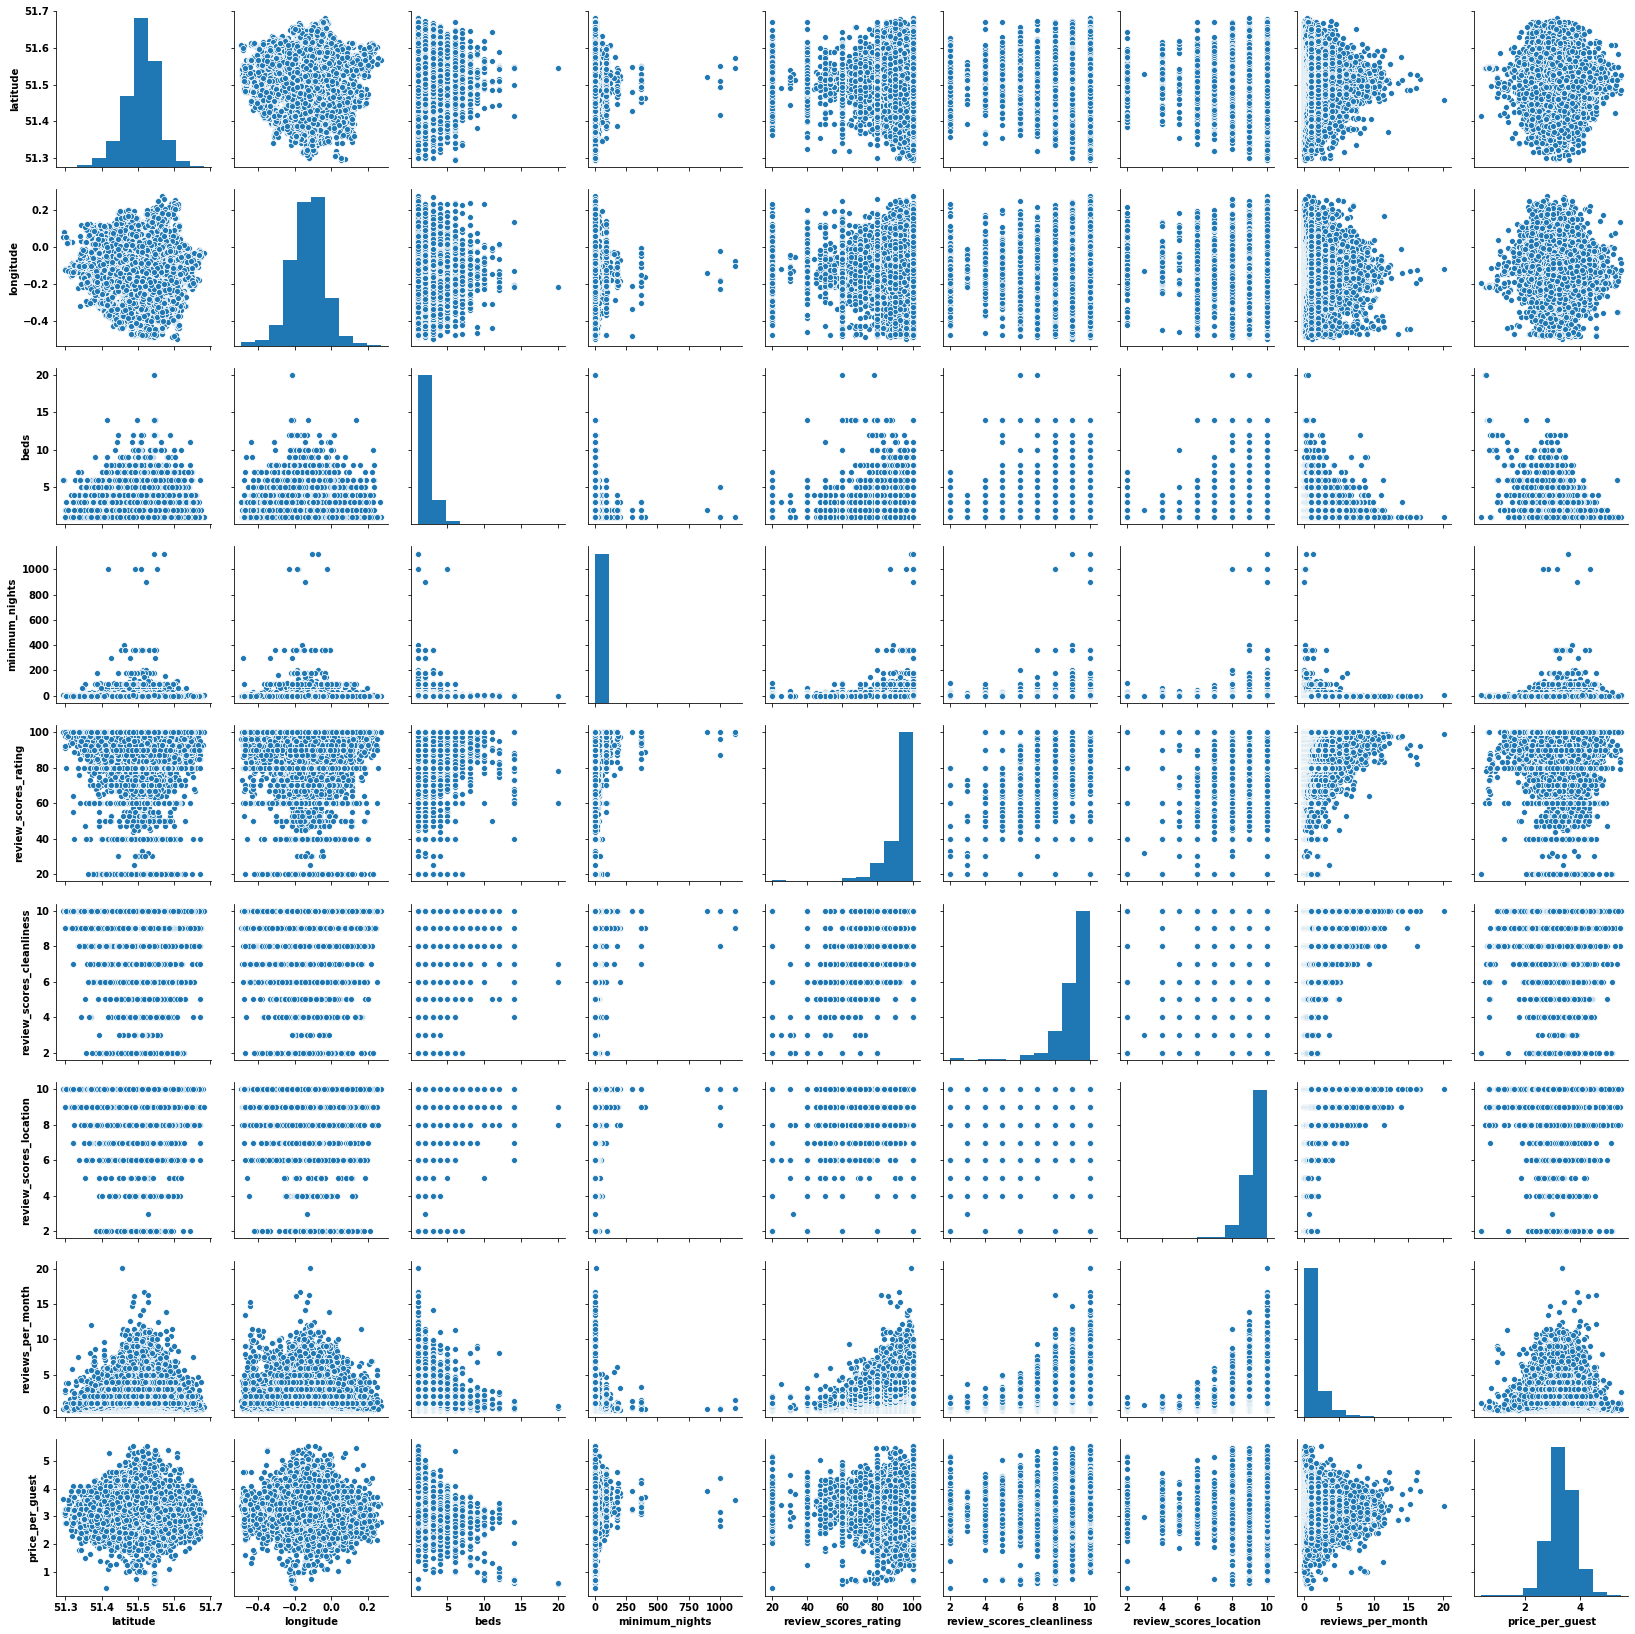

In [20]:
#Let's also check for multi-collinearity visually with pair plots

sns.pairplot(data_listings[['neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'beds', 'bed_type', 'amenities', 'price',
       'minimum_nights', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location','reviews_per_month',
       'price_per_guest']])

### 5a. Transform neighbourhood and geographical attributes 
#### The latitude and longitude variables reflect a "quadratic relation with price per guest". This in line with our expectation of central London house prices. We will explore this relationship visually and apply a transformation to make it consummable in linear regression.

In [21]:
#zonation data
Zone1=["City of London", "Camden", "Hackney", "Islington", "Kensington and Chelsea", "Southwark", "Westminster"]
Zone2=["Greenwich", "Hackney", "Hammersmith and Fulham", "Lewisham", "Tower Hamlets", "Wandsworth","Lambeth"]
Zone3=["Barnet", "Brent", "Bromley", "Croydon", "Ealing","Hounslow", "Newham", "Richmond upon Thames", "Waltham Forest"]
Zone4=["Barking and Dagenham", "Bexley","Enfield", "Haringey","Merton", "Newham", "Redbridge", "Sutton","Kingston upon Thames"]
Zone5=["Harrow", "Hillingdon","Havering"]

#count=1
zones= [Zone1,Zone2,Zone3,Zone4,Zone5]
mapping=dict()
for bo in data_listings.neighbourhood_cleansed.unique():
    if bo in (Zone1 + Zone2 + Zone3 + Zone4 + Zone5):
        for count,zns in enumerate(zones):
            if bo in zns:
                mapping[bo]="Zone" + str(count+1)
    else:
        print(bo)
        


def zonify(neighbourhood_cleansed):
    return(mapping.get(neighbourhood_cleansed))

In [22]:
data_listings["Fare_Zone_Rough"]=data_listings['neighbourhood_cleansed'].apply(zonify)

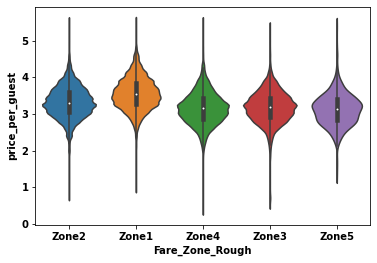

In [23]:
sns.violinplot(x="Fare_Zone_Rough",y="price_per_guest",data=data_listings, figsize=(12,10),c='viridis')

### We can see slight variability affected by zonation.

In [24]:
def generateBaseMap(default_location=[51.4975, 0.0007], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [25]:
from folium.plugins import HeatMap
from folium.plugins import Fullscreen

df_copy = data_listings[:1000].copy()
#Let's get a weighting for the heatmap
data_listings['pppg_prop']=data_listings['price_per_guest']/data_listings.price_per_guest.max()
base_map = generateBaseMap()
HeatMap(data=data_listings[['latitude', 'longitude','pppg_prop']][:30000], radius=8, max_zoom=13,blur=15).add_to(base_map);
base_map
base_map.add_child(Fullscreen(position='topleft', title='Full Screen', title_cancel='Exit Full Screen', force_separate_button=False))


In [28]:
base_map.save("Try.png")

#### So let's retain the Fare Zone variables

## 6. Feature Engineering

### We will attempt to create an additional variable using k-means clustering. Additionally, we will also process categorical variables with One Hot Encoding.

In [24]:
for field in ['require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']:
    data_listings[field]=data_listings[field].map({'t':(field +' true'),'f':(field +' false')})

In [25]:
cates=data_listings[['room_type','bed_type','Fare_Zone_Rough','property_type','cancellation_policy','require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic']]
data_listings=pd.concat([data_listings,pd.get_dummies(data=cates, drop_first=True)], axis=1)
data_listings.head()

id last_scraped                                               name  \
0  11551   2019-11-06         Arty and Bright London Apartment in Zone 2   
3  38407   2019-11-06                  Canary Wharf Immaculate Apt for 2   
4  90700   2019-11-06                  Sunny Notting Hill flat & terrace   
5  15400   2019-11-06                Bright Chelsea  Apartment. Chelsea!   
6  92399   2019-11-06  MODERN SELF CONTAINED ARCHITECT FLATLET, ISLIN...   

                                             summary  \
0  Unlike most rental apartments out there my fla...   
3  The bright, light and stylish apartment in Can...   
4  This is a home not a hotel - for the cost gues...   
5  Lots of windows and light.  St Luke's Gardens ...   
6  FULLY SELF CONTAINED. A  newly renovated, self...   

                                               space  \
0  Amenities Bedding: 1 Double bed, 1 living room...   
3  An entire bright, light and stylish apartment....   
4  This charming 1 bedroom with en-suite bathroom...   
5  Bright Chelsea Apartment  This is a bright one...   
6  Highly convenient, centrally located and newly...   

                                         description experiences_offered  \
0  Unlike most rental apartments out there my fla...              family   
3  The bright, light and stylish apartment in Can...                none   
4  This is a home not a hotel - for the cost gues...                none   
5  Lots of windows and light.  St Luke's Gardens ...            romantic   
6  FULLY SELF CONTAINED. A  newly renovated, self...            business   

                               neighborhood_overview  \
0  Not even 10 minutes by metro from Victoria Sta...   
3  Very easy to get to all the main sites. The tu...   
4  A quick guide or a run through about the area ...   
5                                     It is Chelsea.   
6  Newington Green is a wonderful little pocket o...   

                                              access  \
0     Guest will have access to the entire apartment   
3  This is a quiet self-contained apartment with ...   
4        The whole place is for our guests to enjoy.   
5  There are two wardrobes for guests exclusive u...   
6  Guest have access to their own space and separ...   

                                         house_rules  host_id  host_since  \
0  No Smoking (very strict) No pets are allowed i...    43039  2009-10-03   
3         Respect both check-in and check-out times.   164566  2010-07-12   
4  Full rules will be provided on arrival but the...   491286  2011-04-07   
5  NO SMOKING PLEASE.. No unauthorised guests. No...    60302  2009-12-05   
6  HOUSE RULES: For those who are new to Airbnb, ...   497366  2011-04-10   

                                          host_about        host_is_superhost  \
0  Hello, I'm a friendly Italian man with a very ...   host_is_superhost true   
3  A entire bright, light and stylish apartment. ...  host_is_superhost false   
4  I am a curator working for a gallery in Mayfai...  host_is_superhost false   
5  English, grandmother,  I have travelled quite ...  host_is_superhost false   
6  We are Architects, working and living in Londo...   host_is_superhost true   

   host_total_listings_count       host_has_profile_pic  \
0                        3.0  host_has_profile_pic true   
3                        1.0  host_has_profile_pic true   
4                        2.0  host_has_profile_pic true   
5                        1.0  host_has_profile_pic true   
6                        3.0  host_has_profile_pic true   

   neighbourhood_cleansed  latitude  longitude property_type        room_type  \
0                 Lambeth  51.46225   -0.11732     Apartment  Entire home/apt   
3           Tower Hamlets  51.49995   -0.02624     Apartment  Entire home/apt   
4  Kensington and Chelsea  51.51074   -0.19853         House  Entire home/apt   
5  Kensington and Chelsea  51.48796   -0.16898     Apartment  Entire home/apt   
6               Islington  51.5507

In [26]:
# drop the original variables

#data_listings.drop(['Fare_Zone_Rough','property_type','cancellation_policy','require_guest_profile_picture','instant_bookable','host_is_superhost','host_has_profile_pic'],axis=1,inplace=True)
data_listings.isnull().sum()[data_listings.isnull().sum()>0]

name                         6
summary                   1964
space                    14359
description                901
neighborhood_overview    17255
access                   22127
house_rules              21850
host_about               22640
dtype: int64

### 6a. Now that we have encoded our categorical variables, let's try to deploy unsupervised learning to identify the ideal number of clusters. 

In [27]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Casa particular (Cuba)',
       'property_type_Chalet', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house',
       'property_type_Farm stay', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Minsu (Taiwan)',
       'property_type_Nature lodge', 'property_type_Other',
       'property_type_Ryokan (Japan)', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'require_guest_profile_picture_require_guest_profile_picture true',
       'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true',
       'host_has_profile_pic_host_has_profile_pic true','bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed','room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room']]

In [28]:
Y=data_listings.price_per_guest
from sklearn.model_selection import train_test_split
X_train_cluster, X_test_cluster, Y_train_cluster, Y_test_cluster = train_test_split(X, Y, test_size = .20, random_state = 40)

In [29]:
from sklearn import metrics
from sklearn.cluster import KMeans
inertias = []
ss = []


for k in range(2,11):
    
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_train_cluster)
    inertias.append(kmeans.inertia_)
    ss.append(metrics.silhouette_score(X_train_cluster, kmeans.labels_, metric='euclidean'))

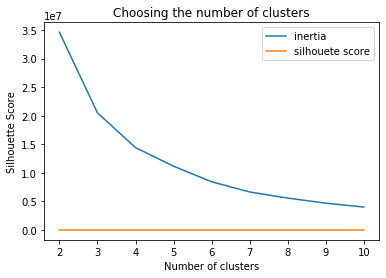

In [36]:
mpl.pyplot.plot(range(2, 11), inertias,label='inertia')
mpl.pyplot.title('Choosing the number of clusters')
mpl.pyplot.xlabel('Number of clusters')
mpl.pyplot.ylabel('Inertia')
mpl.pyplot.plot(range(2, 11), ss,label='silhouete score')
mpl.pyplot.title('Choosing the number of clusters')
mpl.pyplot.xlabel('Number of clusters')
mpl.pyplot.ylabel('Silhouette Score')
mpl.pyplot.legend()
mpl.pyplot.show()


### We observe there is a trade-off between inertia and the silhouette score, but the first bend in the elbow is near the 4 mark and hence we will retain 4 clusters.

In [37]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit_predict(X)
data_listings['clustered']=kmeans.labels_
data_listings.clustered.head()

0    1
3    1
4    3
5    2
6    3
Name: clustered, dtype: int32

Text(0, 0.5, 'Price per guest')

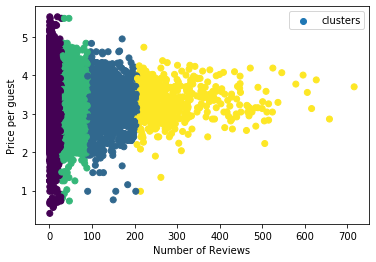

In [38]:
# With multivariate clustering, it can be hard to visualise the clusters, but we can see if some natural segmentation occurs element-wise.
mpl.pyplot.scatter(data_listings.number_of_reviews,data_listings.price_per_guest,c=data_listings.clustered,label="clusters")
mpl.pyplot.legend(loc='upper right')
mpl.pyplot.xlabel('Number of Reviews')
mpl.pyplot.ylabel('Price per guest')

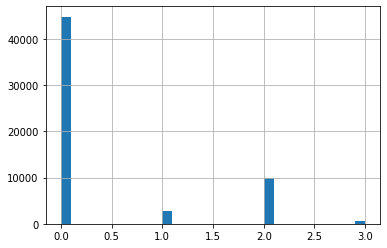

In [39]:
data_listings.clustered.hist(bins=30);

### From the above see that it is not a clearly weighted sample, but for the purpose of our non-parametric machine learning models e.g Random Forests, this should be okay.
#sns.pairplot(data_listings, hue='clustered');

C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\isimr\Anaconda3\lib\site-packages\statsmodels\no

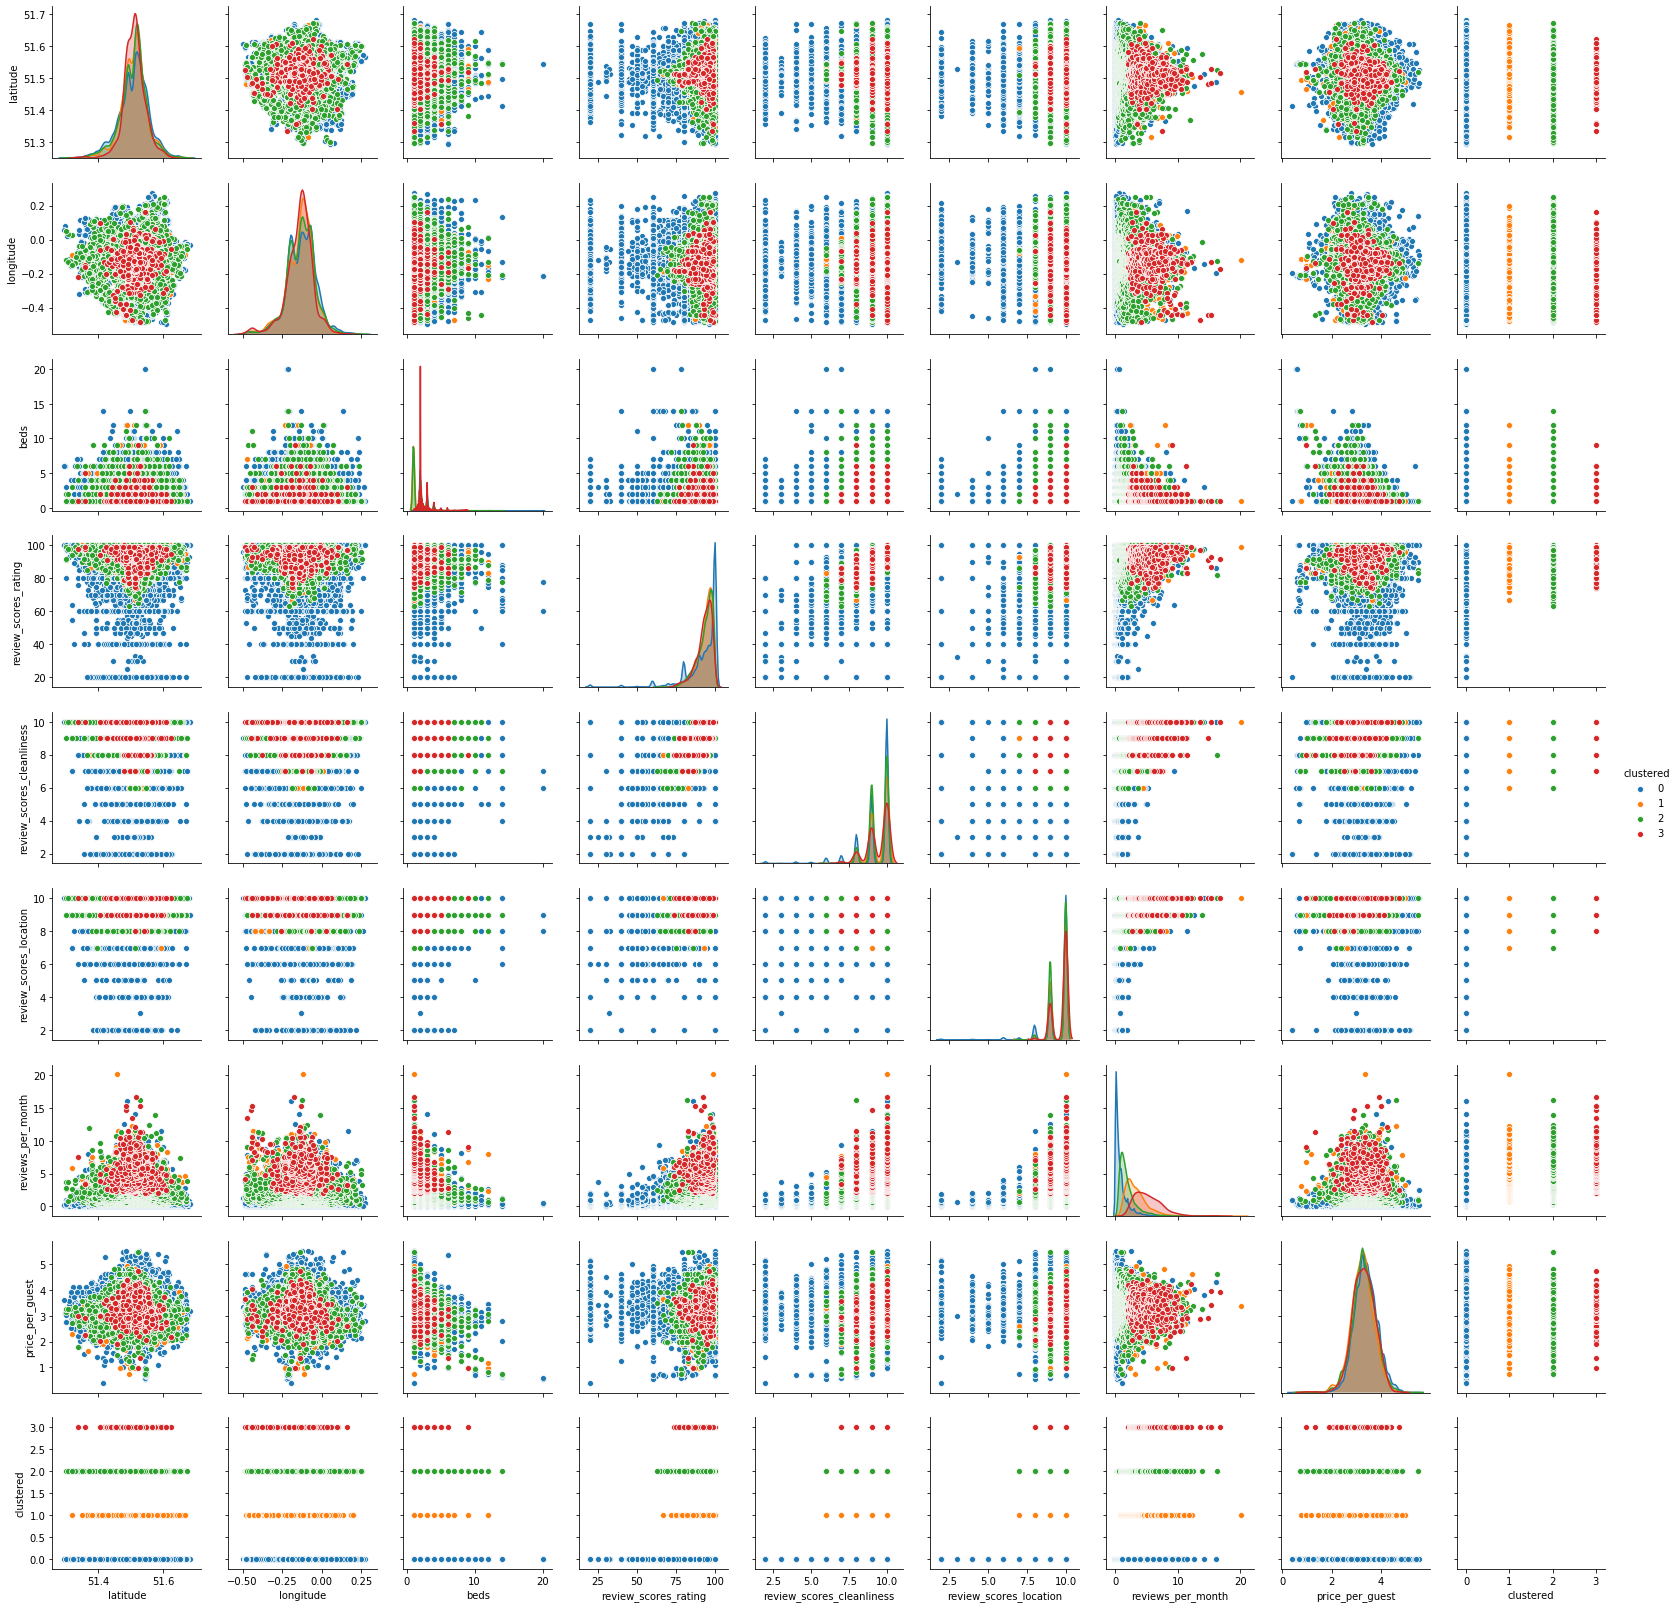

In [40]:
#with clustered data
sns.pairplot(data_listings[['neighbourhood_cleansed', 'latitude', 'longitude',
       'room_type', 'beds', 'bed_type', 'amenities', 'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month',
       'price_per_guest','clustered']], hue='clustered')

## 7. Feature Selection

### Let's perform some preliminary analyis on our variable since the encoding has blow up our variable count. Using the OLS library, we will drop the ones that prove to be insignificant.

In [41]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Casa particular (Cuba)',
       'property_type_Chalet', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house',
       'property_type_Farm stay', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Minsu (Taiwan)',
       'property_type_Nature lodge', 'property_type_Other',
       'property_type_Ryokan (Japan)', 'property_type_Serviced apartment',
       'property_type_Tent', 'property_type_Tiny house',
       'property_type_Townhouse', 'property_type_Treehouse',
       'property_type_Villa', 'property_type_Yurt',
       'require_guest_profile_picture_require_guest_profile_picture true',
       'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true',
       'host_has_profile_pic_host_has_profile_pic true','bed_type_Couch', 'bed_type_Futon',
       'bed_type_Pull-out Sofa', 'bed_type_Real Bed','room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room','clustered']]

In [42]:
#split the data into simple train_test_split
Y=data_listings.price_per_guest
from sklearn.model_selection import train_test_split
X_train_prel, X_test_prel, Y_train_prel, Y_test_prel = train_test_split(X, Y, test_size = .20, random_state = 40)

In [43]:
#try ols
import statsmodels.api as sm

X = sm.add_constant(X_train_prel)
model = sm.OLS(Y_train_prel, X)
results = model.fit()
results.summary()

C:\Users\isimr\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_guest   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     319.7
Date:                Wed, 26 Feb 2020   Prob (F-statistic):               0.00
Time:                        14:42:10   Log-Likelihood:                -23533.
No. Observations:               46434   AIC:                         4.717e+04
Df Residuals:                   46380   BIC:                         4.765e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
const                                                                3.6224      0.137     26.394      0.000       3.353       3.891
beds                                                                -0.1428      0.002    -74.816      0.000      -0.146      -0.139
number_of_reviews                                                -1.861e-05   6.57e-05     -0.283      0.777      -0.000       0.000
review_scores_rating                                                -0.0033      0.000    -11.333      0.000      -0.004      -0.003
review_scores_cleanliness                                            0.0384      0.002     15.479      0.000       0.034       0.043
review_scores_location                                               0.0741      0.003     27.257      0.000       0.069       0.079
reviews_per_month                                                   -0.0199      0.002    -11.888      0.000      -0.023      -0.017
Fare_Zone_Rough_Zone3                                               -0.1785      0.006    -31.020      0.000      -0.190      -0.167
Fare_Zone_Rough_Zone4                                               -0.1957      0.007    -29.515      0.000      -0.209      -0.183
Fare_Zone_Rough_Zone5                                               -0.2309      0.015    -15.243      0.000      -0.261      -0.201
property_type_Apartment                                             -0.4368      0.080     -5.446      0.000      -0.594      -0.280
property_type_Barn                                                  -0.5921      0.246     -2.411      0.016      -1.073      -0.111
property_type_Bed and breakfast                                     -0.2632      0.082     -3.197      0.001      -0.425      -0.102
property_type_Boat                                                  -0.3225      0.101     -3.181      0.001      -0.521      -0.124
property_type_Boutique hotel                                         0.0020      0.095      0.021      0.983      -0.183       0.187
property_type_Bungalow                                              -0.3849      0.091     -4.209      0.000      -0.564      -0.206
property_type_Cabin                                                 -0.4960      0.134     -3.699      0.000      -0.759      -0.233
property_type_Camper/RV                                             -0.5312      0.163     -3.255      0.001      -0.851      -0.211
property_type_Casa particular (Cuba)                                -0.3682      0.216     -1.702      0.089      -0.792       0.056
property_type_Chalet                                                -0.3801      0.197     -1.931      0.054      -0.766       0.006
property_type_Condominiu

In [44]:
# At significant level of 0.05: 
#remove property type barn, property type bed and breakfast, property_type_boat, property type boutique hotesl ,property_type apartment,propoerty type bungalow,propoerty type cabin, property type camper,propoerty type casa, porperty tyep chalet,
#remove porperty condo, property type cottage, porperty type earth, propoerty type farm stay, propoerty type guest suite, property type guest house, propoerty type hotel, propoerty type house, property type house boat, hut, island
#lighthouse, loft, minsu.nature lodge, other ryokan, service apartment, propoerty type tent, propoerty tiny house
#real bed, pull out sodfa, futon, couch, host profile pic, requires guest profile, yurt,villa

In [45]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Other',
        'property_type_Serviced apartment', 'property_type_Tiny house', 'property_type_Treehouse',
       'property_type_Villa',
       'require_guest_profile_picture_require_guest_profile_picture true',
       'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true',
       'host_has_profile_pic_host_has_profile_pic true', 'room_type_Private room',
       'room_type_Shared room','clustered']]

#### Let's acknowledge the very low R2_score - of just 0.26. This is not a very strong model. However, additional features may boost the R2 - this already suggests we should be using Gradient Boosting algorithms to minimise the error at each learning point.

## 8. Natural Language Processing
### An exciting part of this dataset is the volume of text based content that can unfurl some interesting attributes. A separate data set contains all reviews but we will only cosider this as the "stretch" of the project.

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         # Naive Bayes
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
import nltk

%matplotlib inline

In [47]:
# Early attempts showed we had a series of non-english characters - we will simply replace them stringwise
text_fields=['amenities','summary','space', 'description', 'experiences_offered', 'neighborhood_overview']
for field in text_fields:
    data_listings[field]= data_listings[field].str.replace(r'[^\x00-\x7F]+', '')

In [48]:
data_listings['text_all']=data_listings['name']+" "+data_listings['summary']+' '+data_listings['amenities']+" "+data_listings['neighborhood_overview']

In [49]:
#drop where text_all is null
data_listings.drop(data_listings[data_listings.text_all.isnull()].index.values,axis=0, inplace=True)

In [50]:
X=data_listings[['beds','number_of_reviews',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Other',
        'property_type_Serviced apartment', 'property_type_Tiny house', 'property_type_Treehouse',
       'property_type_Villa',
       'require_guest_profile_picture_require_guest_profile_picture true',
       'instant_bookable_instant_bookable true',
       'host_is_superhost_host_is_superhost true',
       'host_has_profile_pic_host_has_profile_pic true', 'room_type_Private room',
       'room_type_Shared room','clustered','text_all']]

In [51]:
y=data_listings.price_per_guest
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### Using the wordcloud code below, I was exploring the general type of words we may encounter.

In [52]:
# text_string=data_listings.text_all.str.cat(sep='')
# from PIL import Image
# from wordcloud import WordCloud
# wordcloud = WordCloud(width = 8000, height = 8000, 
#                 background_color ='white', 
#                 stopwords = stop, 
#                 min_font_size = 10).generate(text_string)
# mpl.pyplot.figure(figsize=(15,8))
# mpl.pyplot.imshow(wordcloud)

#here's the NLP WordCloud
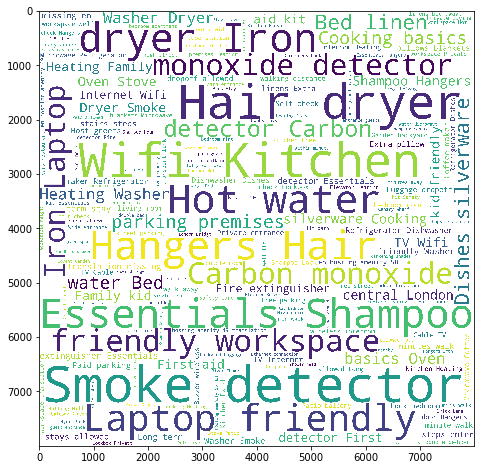

In [53]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append('or')
stop.append('in')
stop.append('to')
stop.append('km')
stop.append('the')
stop.append('in')
stop.append('of')

#We're appedning words we had seen earlier and would like to get rid of
stemmer = PorterStemmer()
lemma= WordNetLemmatizer()
# Stem each word.
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (lemma.lemmatize(w) for w in analyzer(doc))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\isimr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### In a "rough" notebook, we had compared the strength using normla counte vectorizer and tf-idf vectorizer and had a greater r2 using that.

In [56]:
from sklearn.ensemble import RandomForestRegressor
tfid_vect=TfidfVectorizer(lowercase=True,stop_words=stop,analyzer=stemmed_words,min_df=3,ngram_range=(1,3))
rf_reg=RandomForestRegressor()
X_train_dtm = tfid_vect.fit_transform(X_train.text_all)
print(('Features: ', X_train_dtm.shape[1]))
X_test_dtm = tfid_vect.transform(X_test.text_all)
rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train_dtm, y_train)
y_pred_class = rf_reg.predict(X_test_dtm)
print(('Accuracy: ', r2_score(y_test, y_pred_class)))
#(tfid_vect.get_feature_names())

('Features: ', 13183)
('Accuracy: ', 0.30909771459987856)


In [55]:
from sklearn.metrics import r2_score


#### We have not tuned the regression tree above, time permitting, it would have been nice to. We can however, tune our GradientBoosting trees later.

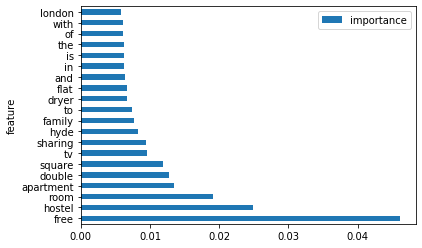

In [57]:
feature_importance =pd.DataFrame({'feature':tfid_vect.get_feature_names(), 'importance':rf_reg.feature_importances_}).sort_values(by='importance',ascending=False)
feature_importance[:20].plot('feature','importance',kind='barh')
#pd.DataFrame(tfid_vect.fit_transform(X_test).toarray(), columns=tfid_vect.get_feature_names())

#### The algorith needs finer tuning to get rid of the stop words (it seems to have missed a good chunk. Let's bring this all together using sparse matrices for the other variables and applying a final round of boosting algorithms.

## 9. Sparse Matrices and Gradient Boosting

In [58]:
import scipy as sp
extra =sp.sparse.csr_matrix(X_train.drop('text_all',axis=1)).astype('float')
extra.shape

(30189, 41)

In [59]:
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))
X_train_dtm_extra.shape
extra = sp.sparse.csr_matrix(X_test.drop('text_all', axis=1).astype(float))
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
X_test_dtm_extra.shape

(10064, 13224)

### Gradient Boosting and Tuning Parameters

#### a previous tuning exercise showed peak perfomance at max depth =12, see code for parameter tuning.

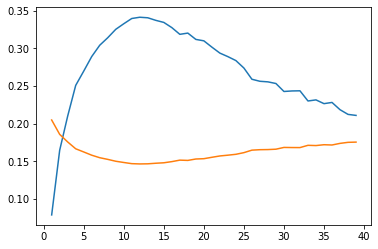

#### max number of features  =7900

In [60]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [ ]:

# r2_list=[]
# mse_list=[]
# parameter_tuning= list(range(1, 9131))
# for param in parameter_tuning:
#     params = {'max_features': 9130, 'min_samples_split': 2,
#               'learning_rate': 0.01, 'loss': 'ls','max_depth':12}
#     clf = GradientBoostingRegressor(**params)

#     clf.fit(X_train_dtm_extra,y_train)
#     mse_list.append(mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
    
#     r2_list.append(r2_score(y_test,clf.predict(X_test_dtm_extra)))



In [62]:
params = {'max_features': 7600, 'min_samples_split': 2,
              'learning_rate': 0.01, 'loss': 'ls','max_depth':12, 'n_estimators':500}
clf = GradientBoostingRegressor(**params)

%timeit clf.fit(X_train_dtm_extra,y_train)
print("MSE: ",mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
print("R2 Score: ",r2_score(y_test,clf.predict(X_test_dtm_extra)))


1h 1min 7s ± 23min 1s per loop (mean ± std. dev. of 7 runs, 1 loop each)
MSE:  0.11996569859381899
R2 Score:  0.449315338282258


### This is our final model R2_score.
### See below for additional tuning code.

In [122]:
# #depth =9, max features
# r2_list=[]
# mse_list=[]
# parameter_tuning= list(range(7500, 13224,100))
# for param in parameter_tuning:
#     params = {'max_features': param, 'min_samples_split': 2,
#               'learning_rate': 0.01, 'loss': 'ls','max_depth':12}
#     clf = GradientBoostingRegressor(**params)

#     clf.fit(X_train_dtm_extra,y_train)
#     mse_list.append(mean_squared_error(y_test, clf.predict(X_test_dtm_extra)))
    
#     r2_list.append(r2_score(y_test,clf.predict(X_test_dtm_extra)))

# import timeit
# timeit

(0.32055539631002694, 7600)

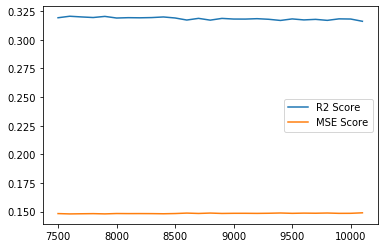

In [120]:
len(r2_list)
len(parameter_tuning[:27])
mpl.pyplot.plot(parameter_tuning[:27],r2_list,label="R2 Score");
mpl.pyplot.plot(parameter_tuning[:27],mse_list,label="MSE Score");
mpl.pyplot.legend();
sorted(zip(r2_list, parameter_tuning[:27]))[-1]


### Plotting the deviance between training and test model

Text(0, 0.5, 'Deviance')

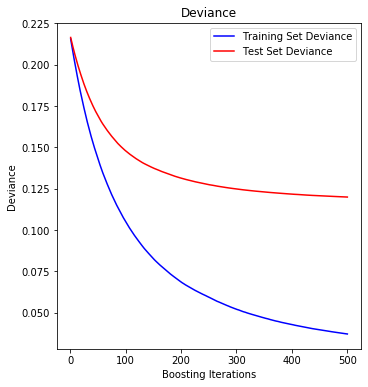

In [63]:
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test_dtm_extra)):
    test_score[i] = clf.loss_(y_test, y_pred)

mpl.pyplot.figure(figsize=(12, 6))
mpl.pyplot.subplot(1, 2, 1)
mpl.pyplot.title('Deviance')
mpl.pyplot.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
mpl.pyplot.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
mpl.pyplot.legend(loc='upper right')
mpl.pyplot.xlabel('Boosting Iterations')
mpl.pyplot.ylabel('Deviance')



### As expected we see a large divergence between the training set and the test set. This is a consequence of the limit fit with an R2_score of 0.45 

## The Final Product: 
### GradientBoosting Model fit on a sparse matrix of tf-idf vector and data_listing features

MoviePy - Building file outputName2.gif with imageio.


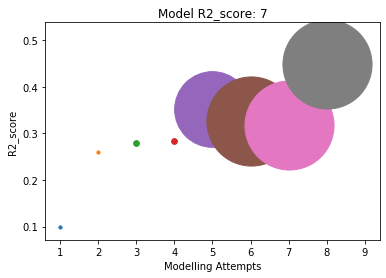

In [64]:
attempt_data = {"Model_Iter":[1,2,3,4,5,6,7,8],"R2_Score":[0.10,0.26,0.280380019399908,0.2831359818817798,0.3522388190740968,0.3278027497723598,0.31852965100776354,0.4497024717780622],"Model Complexity":[17,17,55,55,9549,13244,13224,13224],"Model":['Linear','Linear','DecisionTree','DecisionTree','NLP- Random Forest','GradientBoostingRF','GradientBoostingRF','GradientBoostingRF']}
attempts_pd = pd.DataFrame(attempt_data)
attempts_pd["size"]=0.6*attempts_pd["Model Complexity"]

#modeldevelopment gif code below:
for i in range(8):
    mpl.pyplot.xlabel("Modelling Attempts")
    mpl.pyplot.ylabel("R2_score")
    mpl.pyplot.title("Model R2_score: "+str(i) )
    filename=str(i)+".png"
    mpl.pyplot.scatter(attempts_pd.loc[i].Model_Iter,attempts_pd.loc[i].R2_Score,s=attempts_pd.loc[i]["size"])
    mpl.pyplot.savefig(filename, dpi=96);

import glob
import os

gif_name = 'outputName'
file_list = glob.glob('*.png') # Get all the pngs in the current directory
#list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case

with open('image_list.txt', 'w') as file:
    for item in file_list:
        file.write("%s\n" % item)

os.system('convert @image_list.txt {}.gif'.format(gif_name))

import glob
import moviepy.editor as mpy

gif_name = 'outputName2'
fps = 0.5
file_list = glob.glob('*.png') # Get all the pngs in the current directory
#list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images by #, this may need to be tweaked for your use case
clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_gif('{}.gif'.format(gif_name), fps=fps)

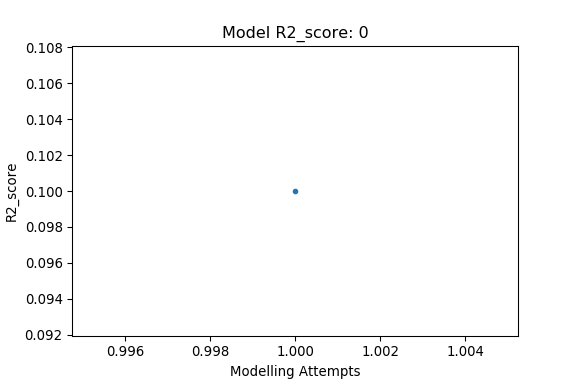

#### As we can see, introducing complexity and choosing more powerful models helped boost the R2_score. The chart shows the journey with base model attempts (without tuning iterations). The size of the marker signifies the number of attributes.
#### However, a score of 0.45 is still not significant enough.

## Last Mile : One final Stretch
### 9. Let's dance shall we? The Model in action.

In [221]:
import requests
import urllib
import re
from bs4 import BeautifulSoup
#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
url_ex='https://www.airbnb.co.uk/rooms/5440213?previous_page_section_name=1000&search_id=cf9be51e-6255-0a19-79fc-fc8a8fccae53&federated_search_id=c9c8aaad-b5ef-4ac0-a760-4fc0415ee174'
example1= requests.get(url_ex)
soup =BeautifulSoup(example1.content,'html.parser')
name=(soup.find(id='summary').find('span',class_= '_18hrqvin')).text
listing_info = (soup.find_all(class_='_36rlri',style="margin-right:24px"))
guests=int(listing_info[0].text.split(" guest")[0])
property_type=listing_info[1].text.split(" beds")[0]
beds_no = int(listing_info[2].text.split(" bed")[0])
#superhost - default is 1
summary_listing=soup.find(id='details').find('span',class_= '_czm8crp').text
review_score_overall=float(soup.find(id='reviews').find('div',class_= '_1iv05u9z').text[:4])
review_score_loc=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[0].text)
review_score_clean=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[4].text)
zone_dummy=mapping.get('Barnet')
neighbourhood_ov=str(input("Neighboughood Overview here: "))
review_no= soup.find(id='reviews').find('span',class_= '_krjbj').text[:4]


Neighboughood Overview here: Heart Of London’s place is located in Greater London, England, United Kingdom. Westminster is the best location to start exploring London! With all the world- renowned landmarks at your doorstep, like the Houses of Parliament, Big Ben, Westminster Abbey and Buckingham Palace, the bustling local bistros and bars, and lush green open spaces like Hyde Park and Green Park, this make the location a comfortable, desirable and welcoming place.  Eating out: The area is absolutely amazing when it comes to eating out. Within a 5 minute distance you will find a variety of nice local cafes, bars pubs and restaurants, as well as well known chain establishments. You can really find any possible cuisine you can imagine- British, French, Chinese, Italian, Indian, Brazilian, Portuguese, Belgian, Spanish, etc.  Shopping: - 3 major supermarkets within a few minute walk - Victoria Shopping Centre- 7 min walk - Cardinal Place Shopping centre- 8 min walk - Victoria Street with a

In [212]:
name=(soup.find_all(tabindex='-1',class_= '_14i3z6h'))#.text
# listing_info = (soup.find_all(class_='_36rlri',style="margin-right:24px"))
# guests=int(listing_info[0].text.split(" guests")[0])
# property_type=listing_info[1].text.split(" beds")[0]
# beds_no = int(listing_info[2].text.split(" bed")[0])
# #superhost - default is 1
# summary_listing=soup.find(id='details').find('span',class_= '_czm8crp').text
# review_score_overall=float(soup.find(id='reviews').find('div',class_= '_1iv05u9z').text[:4])
# review_score_loc=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[0].text)
# review_score_clean=float((soup.find(id='reviews').find_all(class_='_1p3joamp'))[4].text)
# zone_dummy=mapping.get('Barnet')
# neighbourhood_ov=str(input("Neighboughood Overview here: "))
# review_no= soup.find(id='reviews').find('span',class_= '_krjbj').text[:4]


In [215]:
name=name[0].text

In [218]:
selector=widgets.SelectMultiple(
    options=['Microwave','Dishwasher','Refrigerator','Stove','Lift','Laptop-friendly','First aid kit','Fire extinguisher','Wifi', 'Dryer', 'Smoke Detector','Essentials','Heating','Iron','TV','Washing Machine','Kitchen','Hair dryer','Hangers','Carbon monoxide alarm','Air conditioning','Private entrance','shampoo','Hot water',
            'Breakfast'],
    value=['Wifi'],
    rows=15,
    description='Fruits',
    disabled=False
)
display(selector)

SelectMultiple(description='Fruits', index=(8,), options=('Microwave', 'Dishwasher', 'Refrigerator', 'Stove', …

In [219]:
amenities= set()
amenities.add(selector.value)

In [222]:
print("Name: "+name)
print("Guests: "+str(guests))
print("Property Type: "+ str(property_type))
print("Beds No: " + str(beds_no))
print(summary_listing[:150])
print(review_score_overall)
print(review_score_loc)
print(review_score_clean)
print(amenities)

Name: Best single room in Central London
Guests: 1
Property Type: 1 bedroom
Beds No: 1
Beautiful&comfortable single bedroom only 10-min walk to Big Ben. Victoria station within 6-min walk (Victoria Coach Station 8 min). Save time and mon
4.85
5.0
4.9
{('Microwave', 'Dishwasher', 'Refrigerator', 'Stove', 'Lift', 'First aid kit', 'Wifi', 'Smoke Detector', 'Essentials', 'Heating', 'Iron', 'Hair dryer', 'Hangers', 'shampoo')}


In [223]:
fieldsa={'beds', 'number_of_reviews','review_scores_rating','review_scores_cleanliness','review_scores_location',
"require_guest_profile_picture_require_guest_profile_picture true", 'instant_bookable_instant_bookable true','host_is_superhost_host_is_superhost true', 'host_has_profile_pic_host_has_profile_pic true',
'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
       'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Condominium',
       'property_type_Cottage', 'property_type_Earth house', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Other',
        'property_type_Serviced apartment', 'property_type_Tiny house', 'property_type_Treehouse',
       'property_type_Villa',
 'room_type_Private room',
       'room_type_Shared room'}

In [224]:
new_input={}
for col in fieldsa:
    new_input[col]=0

In [226]:
def update_new_input(new_input):
    new_input['beds']=beds_no
    new_input['number_of_reviews']=review_no
    new_input['review_scores_rating']=review_score_overall  
    new_input['review_scores_cleanliness']=review_score_clean
    new_input["require_guest_profile_picture_require_guest_profile_picture true"]=1
    new_input['instant_bookable_instant_bookable true']=1
    new_input['host_is_superhost_host_is_superhost true']=1
    new_input['host_has_profile_pic_host_has_profile_pic true']=1
    new_input['name']=name
    new_input['amenities']=amenities
    new_input['summary']=summary_listing
    new_input['review_scores_location']=review_score_loc
    

In [228]:
#Update as needed using these
property_type=listing_info[1].text.split(" beds")[0]
zone_dummy=mapping.get(input('Type borough here '))
neighbourhood_ov=str(input('Type neighbourhood overview here '))
new_input['neighborhood_overview']=neighbourhood_ov    
text_string= name+ " " + summary_listing +" " + str(amenities) + " "+ neighbourhood_ov
new_input['text_all']=text_string;
zone_dummy

Type borough here Victoria
Type neighbourhood overview here Heart Of London’s place is located in Greater London, England, United Kingdom. Westminster is the best location to start exploring London! With all the world- renowned landmarks at your doorstep, like the Houses of Parliament, Big Ben, Westminster Abbey and Buckingham Palace, the bustling local bistros and bars, and lush green open spaces like Hyde Park and Green Park, this make the location a comfortable, desirable and welcoming place.  Eating out: The area is absolutely amazing when it comes to eating out. Within a 5 minute distance you will find a variety of nice local cafes, bars pubs and restaurants, as well as well known chain establishments. You can really find any possible cuisine you can imagine- British, French, Chinese, Italian, Indian, Brazilian, Portuguese, Belgian, Spanish, etc.  Shopping: - 3 major supermarkets within a few minute walk - Victoria Shopping Centre- 7 min walk - Cardinal Place Shopping centre- 8 mi

In [229]:
update_new_input(new_input)
new_input

In [231]:
#X_test.drop([10064,10065],inplace=True)

In [106]:
y_test.tail()
np.log1p(19)

2.995732273553991

In [273]:
X_test=X_test.append(new_input,ignore_index=True);
y_test= y_test.append(pd.Series(np.log1p(int(input('Enter Price Here')))))
X_test_trial=X_test.loc[X_test.shape[0]-1].to_frame().T

In [274]:
X_test_dtm_trialed = tfid_vect.transform(X_test_trial.text_all)
pd.DataFrame(tfid_vect.transform(X_test_trial).toarray(), columns=tfid_vect.get_feature_names()).max(axis=0).sort_values(ascending=False)[:20]

summary      1.000000
bed          1.000000
suite        1.000000
true         1.000000
apartment    1.000000
clustered    1.000000
hotel        1.000000
house        1.000000
amenity      1.000000
name         1.000000
room         1.000000
breakfast    0.940971
and          0.338488
emerald      0.000000
emergency    0.000000
emerges      0.000000
emerging     0.000000
emilia       0.000000
emerged      0.000000
emerge       0.000000
dtype: float64

In [256]:
# X=data_listings[['beds','number_of_reviews',
#        'review_scores_rating', 'review_scores_cleanliness',
#        'review_scores_location', 'reviews_per_month','Fare_Zone_Rough_Zone3', 'Fare_Zone_Rough_Zone4',
#        'Fare_Zone_Rough_Zone5', 'property_type_Apartment',
#        'property_type_Barn', 'property_type_Bed and breakfast',
#        'property_type_Boat', 'property_type_Boutique hotel',
#        'property_type_Bungalow', 'property_type_Cabin',
#        'property_type_Camper/RV', 'property_type_Casa particular (Cuba)',
#        'property_type_Chalet', 'property_type_Condominium',
#        'property_type_Cottage', 'property_type_Earth house',
#        'property_type_Farm stay', 'property_type_Guest suite',
#        'property_type_Guesthouse', 'property_type_Hostel',
#        'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
#        'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
#        'property_type_Loft', 'property_type_Minsu (Taiwan)',
#        'property_type_Nature lodge', 'property_type_Other',
#        'property_type_Ryokan (Japan)', 'property_type_Serviced apartment',
#        'property_type_Tent', 'property_type_Tiny house',
#        'property_type_Townhouse', 'property_type_Treehouse',
#        'property_type_Villa', 'property_type_Yurt',
#        'require_guest_profile_picture_require_guest_profile_picture true',
#        'instant_bookable_instant_bookable true',
#        'host_is_superhost_host_is_superhost true',
#        'host_has_profile_pic_host_has_profile_pic true','bed_type_Couch', 'bed_type_Futon',
#        'bed_type_Pull-out Sofa', 'bed_type_Real Bed','room_type_Hotel room', 'room_type_Private room',
#        'room_type_Shared room']]

#del new_input['name']
#del new_input['summary']
#del new_input['amenities']
#del new_input['text_all']
#del new_input['neighborhood_overview']
#del new_input['index']

# new_input.update({'reviews_per_month': 0,
#  'property_type_Earth house': 0,
#  'property_type_House': 0,
#  'property_type_Condominium': 0,
# 'property_type_Barn':0,                                         
#  'property_type_Hut': 0,
#  'property_type_Serviced apartment': 0,
#  'property_type_Cabin': 0,
#  'property_type_Apartment': 0,
#  'property_type_Villa': 0,
#  'Fare_Zone_Rough_Zone3': 0,
#  'property_type_Houseboat': 0,
#  'property_type_Other': 0,
#  'room_type_Shared room': 0,
#   'property_type_Lighthouse': 0,
#  'property_type_Hotel': 0,
#  'property_type_Cottage': 0,
#  'property_type_Treehouse': 0,
#  'Fare_Zone_Rough_Zone5': 0,
#  'property_type_Bungalow': 0,
#  'room_type_Private room': 0,
#  'Fare_Zone_Rough_Zone4': 0,
#  'property_type_Tiny house': 0,
#  'property_type_Bed and breakfast': 0,
#  'property_type_Hostel': 0,
#  'property_type_Boutique hotel': 0,
#  'property_type_Loft': 0,
#  'property_type_Guest suite': 0,
#  'property_type_Boat': 0,
#  'property_type_Guesthouse': 0,
#  'property_type_Barn': 0,
#  'property_type_Camper/RV': 0,
# 'property_type_Casa particular (Cuba)':0,
#         'property_type_Chalet':0, 
# 'property_type_Farm stay':0,
# 'property_type_Island':0,
#  'property_type_Minsu (Taiwan)':0,
# 'property_type_Nature lodge':0, 'property_type_Other':0,
# 'property_type_Ryokan (Japan)':0, 
# 'property_type_Tent':0,
# 'property_type_Townhouse':0, 
# 'property_type_Yurt':0,
# 'bed_type_Couch':0, 'bed_type_Futon':0,
# 'bed_type_Pull-out Sofa':0, 'bed_type_Real Bed':0,
# 'room_type_Hotel room':0})

cluster_dic= pd.DataFrame(new_input,index=[0])
    
cluster_dic

reviews_per_month number_of_reviews  property_type_Earth house  \
0                  0              455                           0   

   property_type_House  property_type_Condominium  property_type_Hut  \
0                    0                          0                  0   

   property_type_Serviced apartment  review_scores_cleanliness  \
0                                 0                        4.9   

   property_type_Cabin  property_type_Apartment  property_type_Villa  \
0                    0                        0                    0   

   Fare_Zone_Rough_Zone3  property_type_Houseboat  property_type_Other  \
0                      0                        0                    0   

   review_scores_rating  instant_bookable_instant_bookable true  \
0                  4.85                                       1   

   room_type_Shared room  host_is_superhost_host_is_superhost true  \
0                      0                                         1   

   property_type_Lighthouse  property_type_Hotel  property_type_Cottage  \
0                         0                    0                      0   

   property_type_Treehouse  Fare_Zone_Rough_Zone5  \
0                        0                      0   

   host_has_profile_pic_host_has_profile_pic true  \
0                                               1   

   require_guest_profile_picture_require_guest_profile_picture true  \
0                                                  1                  

   property_type_Bungalow  room_type_Private room  Fare_Zone_Rough_Zone4  \
0                       0                       0                      0   

   property_type_Tiny house  property_type_Bed and breakfast  \
0                         0                                0   

   property_type_Hostel  property_type_Boutique hotel  property_type_Loft  \
0                     0                             0                   0   

   property_type_Guest suite  beds  property_type_Boat  \
0                          0     1                   0   

   property_type_Guesthouse  property_type_Barn  review_scores_location  \
0                         0                   0                     5.0   

   property_type_Camper/RV  property_type_Casa particular (Cuba)  \
0                        0                                     0   

   property_type_Chalet  property_type_Farm stay  property_type_Island  \
0                     0                        0                     0   

   property_type_Minsu (Taiwan)  property_type_Nature lodge  \
0                             0                           0   

   property_type_Ryokan (Japan)  property_type_Tent  property_type_Townhouse  \
0                             0                   0                        0   

   property_type_Yurt  bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  \
0                   0               0               0                       0   

   bed_type_Real Bed  room_type_Hotel room  
0                  0                     0

In [260]:
findcluster=kmeans.predict(cluster_dic)[0]

In [275]:
X_test.tail(1)

beds number_of_reviews  review_scores_rating  \
10066   1.0              455                   4.85   

       review_scores_cleanliness  review_scores_location  reviews_per_month  \
10066                        4.9                     5.0                0.0   

       Fare_Zone_Rough_Zone3  Fare_Zone_Rough_Zone4  Fare_Zone_Rough_Zone5  \
10066                    0.0                    0.0                    0.0   

       property_type_Apartment  property_type_Barn  \
10066                      0.0                 0.0   

       property_type_Bed and breakfast  property_type_Boat  \
10066                              0.0                 0.0   

       property_type_Boutique hotel  property_type_Bungalow  \
10066                           0.0                     0.0   

       property_type_Cabin  property_type_Camper/RV  \
10066                  0.0                      0.0   

       property_type_Condominium  property_type_Cottage  \
10066                        0.0                    0.0   

       property_type_Earth house  property_type_Guest suite  \
10066                        0.0                        0.0   

       property_type_Guesthouse  property_type_Hostel  property_type_Hotel  \
10066                       0.0                   0.0                  0.0   

       property_type_House  property_type_Houseboat  property_type_Hut  \
10066                  0.0                      0.0                0.0   

       property_type_Lighthouse  property_type_Loft  property_type_Other  \
10066                       0.0                 0.0                  0.0   

       property_type_Serviced apartment  property_type_Tiny house  \
10066                               0.0                       0.0   

       property_type_Treehouse  property_type_Villa  \
10066                      0.0                  0.0   

       require_guest_profile_picture_require_guest_profile_picture true  \
10066                                                1.0                  

       instant_bookable_instant_bookable true  \
10066                                     1.0   

       host_is_superhost_host_is_superhost true  \
10066                                       1.0   

      host_has_profile_pic_host_has_profile_pic true  room_type_Private room  \
10066                                              1                     0.0   

       room_type_Shared room  clustered  \
10066                    0.0        NaN   

                                                text_all  \
10066  Best single room in Central London Beautiful&c...   

                                               amenities  \
10066  {(Microwave, Dishwasher, Refrigerator, Stove, ...   

                                     name  \
10066  Best single room in Central London   

                                   neighborhood_overview  \
10066  Heart Of London’s place is located in Greater ...   

                                                 summary  
10066  Beautiful&comfortable single bedroom only 10-m...

In [269]:
X_test_trial.at[10066,'clustered']=findcluster

In [276]:
#X_test.drop(10065,axis=1,inplace=True)
X_test_trial.tail(1)

beds number_of_reviews review_scores_rating review_scores_cleanliness  \
10066    1              455                  4.85                       4.9   

      review_scores_location reviews_per_month Fare_Zone_Rough_Zone3  \
10066                      5                 0                     0   

      Fare_Zone_Rough_Zone4 Fare_Zone_Rough_Zone5 property_type_Apartment  \
10066                     0                     0                       0   

      property_type_Barn property_type_Bed and breakfast property_type_Boat  \
10066                  0                               0                  0   

      property_type_Boutique hotel property_type_Bungalow property_type_Cabin  \
10066                            0                      0                   0   

      property_type_Camper/RV property_type_Condominium property_type_Cottage  \
10066                       0                         0                     0   

      property_type_Earth house property_type_Guest suite  \
10066                         0                         0   

      property_type_Guesthouse property_type_Hostel property_type_Hotel  \
10066                        0                    0                   0   

      property_type_House property_type_Houseboat property_type_Hut  \
10066                   0                       0                 0   

      property_type_Lighthouse property_type_Loft property_type_Other  \
10066                        0                  0                   0   

      property_type_Serviced apartment property_type_Tiny house  \
10066                                0                        0   

      property_type_Treehouse property_type_Villa  \
10066                       0                   0   

      require_guest_profile_picture_require_guest_profile_picture true  \
10066                                                  1                 

      instant_bookable_instant_bookable true  \
10066                                      1   

      host_is_superhost_host_is_superhost true  \
10066                                        1   

      host_has_profile_pic_host_has_profile_pic true room_type_Private room  \
10066                                              1                      0   

      room_type_Shared room clustered  \
10066                     0       NaN   

                                                text_all  \
10066  Best single room in Central London Beautiful&c...   

                                               amenities  \
10066  {(Microwave, Dishwasher, Refrigerator, Stove, ...   

                                     name  \
10066  Best single room in Central London   

                                   neighborhood_overview  \
10066  Heart Of London’s place is located in Greater ...   

                                                 summary  
10066  Beautiful&comfortable single bedroom only 10-m...

In [277]:
X_test_dtm_trialed
trial_xtra=sp.sparse.csr_matrix(X_test_trial.drop(['amenities','name','neighborhood_overview','summary','text_all'],axis=1).astype(np.float))
trial_xtra.shape

(1, 41)

In [278]:
y_pred_class_trialed = rf_reg.predict(X_test_dtm_trialed)
#print(('Accuracy: ', r2_score(y_test, y_pred_class_trialed)))


In [279]:
np.expm1(y_pred_class_trialed)

array([27.56196524])